In [5]:
#pip install kaggle

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets,models
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
from tqdm import tqdm
import os

import zipfile
import seaborn as sns
import pandas as pd

import cv2
import albumentations as A
import matplotlib.pyplot as plt

from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
import os
import glob
from torch.utils.data import DataLoader

from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [2]:
!kaggle competitions download -c dl-2025-competition-1

dl-2025-competition-1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [15]:
with zipfile.ZipFile("dl-2025-competition-1.zip", 'r') as zip_ref:
     zip_ref.extractall("content/")  

In [3]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience #отвечает за период в течении которого не улучшается метрика 
        self.verbose = verbose
        self.counter = 0 #счетчик увеличивается каждую эпоху, если не было улучшения 
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_model_state = None

    def __call__(self, val_metric, model):
        score = -val_metric  # Assuming lower loss is better
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta: #делта чтобы не сохранялись совсем маленькие приросты 
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0
            
def warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5):
    if epoch < warmup_epochs: # пока идут эпохт вормапа lr изменяется по определенному закону 
        lr = warmup_lr_start + (base_lr - warmup_lr_start) * (epoch / warmup_epochs)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer  

In [34]:
def learn_model(model, train_loader, val_loader,num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
    early_stopping_optimizer_switch = EarlyStopping(patience=2, verbose=True)

    warmup_epochs = 2
    optimizer_switched = False
    base_lr = 0.01

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        if epoch < warmup_epochs:
            optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-4)
        else: 
            scheduler.step()

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets= targets.long().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100. * correct / total

        model.eval()
        running_val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.long().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = 100. * correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        clear_output(wait=True)
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
        plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss over Epochs")
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
        plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy over Epochs")
        plt.legend()
        plt.show()

        print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        early_stopping_optimizer_switch(val_loss, model)
        if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
            print("No improvement after loss switch. Switching optimizer to Adam.")
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            base_lr = 0.001
            optimizer_switched = True
            early_stopping_optimizer_switch = EarlyStopping(patience=2, verbose=True)

## Часть 1 анализ датасета

In [3]:
#разбираемся с путями 
train_path ='content/data/train'

classes = os.listdir(train_path) # все папки внутри train 

class_images={}
class_balance={}
total_images=0
for class_name in classes:
    class_dir = os.path.join(train_path,class_name) #заходим в train и затем в конкретный класс
    files= os.listdir(class_dir)#все файлы внутри одного класса 
    img_path= os.path.join(class_dir,files[0]) #берем из каждого класса по одной картинке 
    class_images[class_name] = img_path #примеры классов 
    class_balance[class_name]=len(files) #считаем сколько всего картинок внутри класса 
    total_images=total_images+len(files)

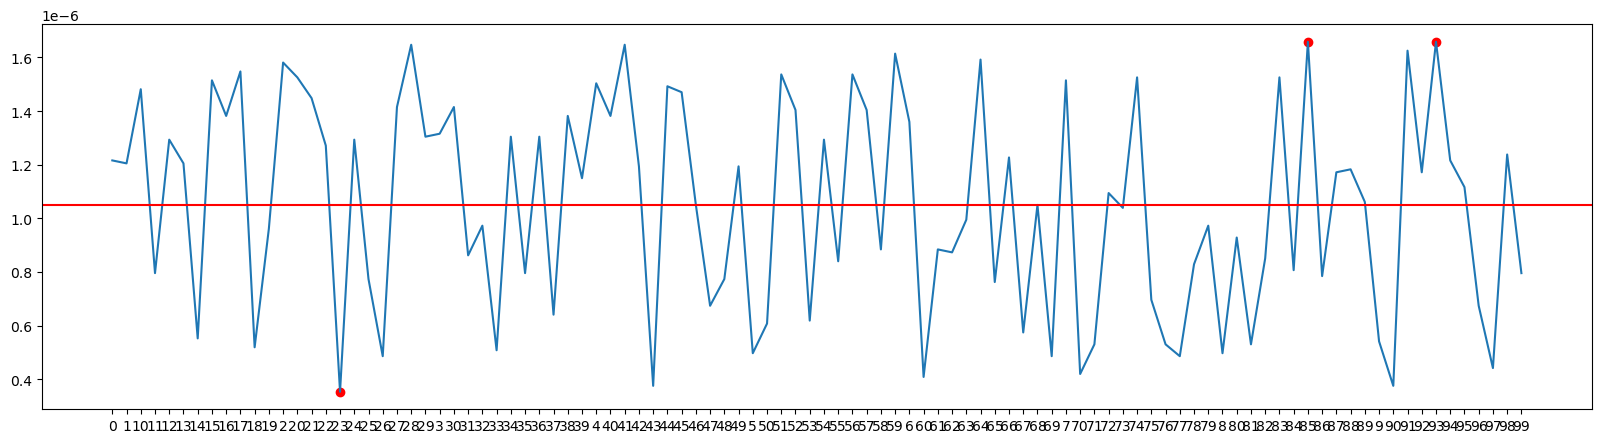

In [6]:
#смотрим на баланс классов, в целом у них небольшой разброс, нет классов которые прям сильно доминируют над остальными, класс с минимальной долей изображений - 32
for i in class_balance.keys():
      class_balance[i]=class_balance[i]/total_images
balance=pd.DataFrame(list(class_balance.items()))

plt.figure(figsize=(20,5))
plt.plot(balance[0],balance[1])
plt.axhline(y=balance[1].mean(),color='r')
plt.scatter(balance[balance[1]==balance[1].min()][0],balance[balance[1]==balance[1].min()][1],color='r')
plt.scatter(balance[balance[1]==balance[1].max()][0],balance[balance[1]==balance[1].max()][1],color='r');

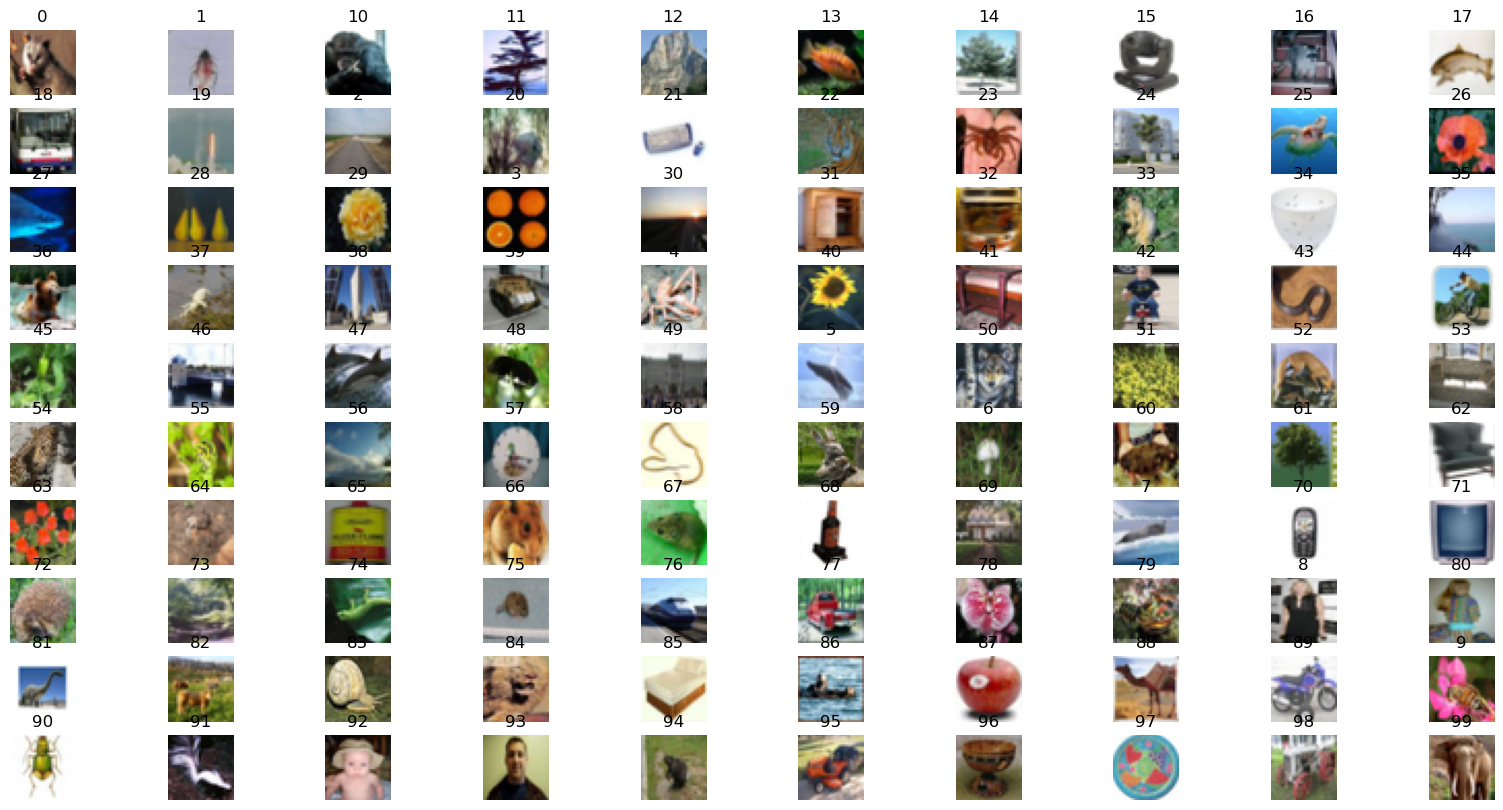

In [7]:
#посмотрим на классы визуально 
plt.figure(figsize=(20,10))
for i, (class_name,img_path) in enumerate(class_images.items()):
    plt.subplot(10,10,i+1)
    img=mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

In [ ]:
#классы довольно разнообразные, у нас тут и люди и животные и предметы, крч отправи ли ребенка с фотиком гулять и вот результат 
#картинки нечеткие и очень размытые => легче будет ловить какие-нибудь локальные признаки 

# что можно попробовать: разные подходы к аугументации тк зашумленные данные или добавить меньшую уверенность модели (чтобы ошибки были с меньшим весом) + dropout 

## Часть 2 аугментация:  
### ❝ Помните: нет никаких «её» или «вас». Вы – одно целое. Уважайте баланс ❞ - The Substance

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Приколдесы с аугментацией: хочетса добавить немного блюра, покрутить картинки вверх вниз и поиграться с цветом-тональностями

Посмотрим, что из этого выйдет на примере этой мыши(?)

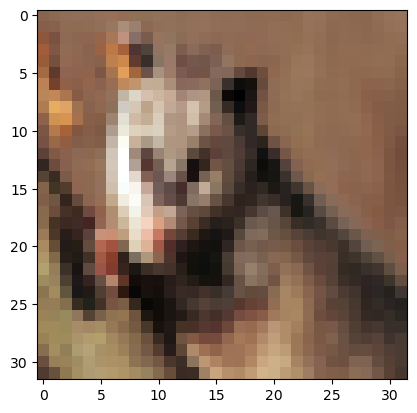

In [67]:
image=mpimg.imread(class_images['0'])
plt.imshow(image)

In [234]:
train_transform = A.Compose([
    A.Resize(224,224,p=1),
    A.HorizontalFlip(p=0.7),
    A.VerticalFlip(p=0.1),
    A.RandomBrightnessContrast(p=0.6),
    
    #тут блок на играние с блюром и прочее
    A.OneOf([
         A.MedianBlur(p=0.5),
         A.GaussianBlur(p=0.5),
         A.GlassBlur(p=0.5),
         A.RandomGamma(p=0.05)
         ], p=0.5),
    
    #блок на поигрушки с цветами 
     A.OneOf([
         A.ToGray(p=0.2),
         A.RGBShift(p=0.2)
         ],p=0.5),
    
    A.PixelDropout(p=0.6),
    A.Normalize(),
    ToTensorV2()
])


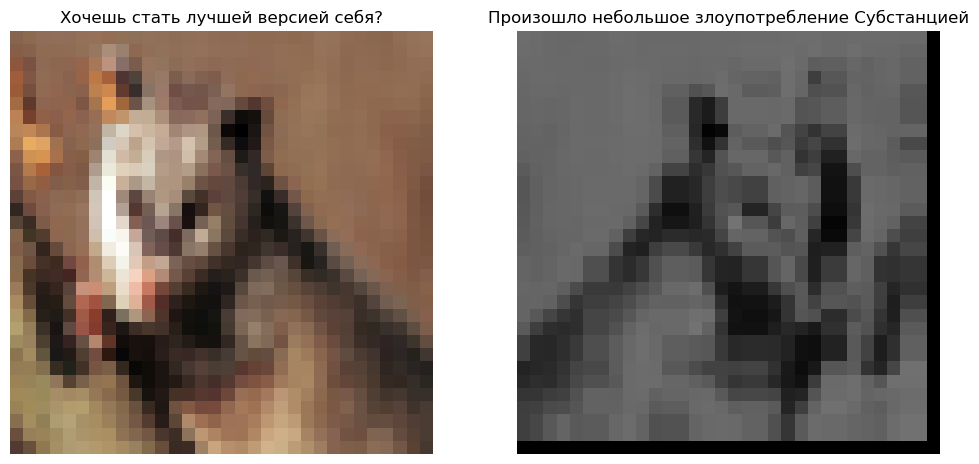

In [110]:
augmented = train_transform(image=image)
aug_image = augmented["image"]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title("Хочешь стать лучшей версией себя?")
ax[0].axis("off")
ax[1].imshow(aug_image)
ax[1].set_title("Произошло небольшое злоупотребление Субстанцией")
ax[1].axis("off")
plt.show()

## Часть 3:

1.Поделить данные на train/valid 

2.Обучить базовую модель без transfer learning и c transfer learning без аугментации 

3.Обучить модели из пункта 2 с навороченной аугментацией и простой аугментацией 

4.На лучшую модель с transfer learning навесить улучшение качества (апскейлинг) 

5.Сделать аугументацию на валидационных данных (или тестовых) 


### 1. Делим данные и создаем приемлимый вид датасетов, определяем transfer learning

Создадим класс My_Dataset, который будет делить наши данные на трейн и валидацию , и класс testdata который работает с тестовым датасетом на котором мы прелсказываем данные, также сразу подгрузим три модели dendnet, mobilenet и efficientnet который пойдут в transfer learning

In [16]:
class testdata(Dataset):
    def __init__(self,transform=None, root_dir="content/data/test"):

        self.transform = transform
        self.root_dir=root_dir
        self.images=sorted(os.listdir(self.root_dir), key=lambda x: int(x.split('.')[0]))
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx): 
        img_path = os.path.join(self.root_dir,self.images[idx]) 
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform: #подаём аугументацию
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

In [17]:
class My_Dataset(Dataset):
    def __init__(self, split='train', transform=None, root_dir="content/data/"):

        self.transform = transform
        self.samples = []
        # пути к файлам тест и трейн
        files_train =os.path.join(root_dir,'train')
        classes = os.listdir(files_train)
        
        def split_files(files, split):
            n = len(files) #сколько всего картинок внутри класса 
            if split == 'train':
                return files[:int(0.7 * n)]
            elif split == 'val':
                return files[int(0.7 * n):]
            else:
                return files
                
        #train->class-> деление  на трейн и валидацию 
        for class_name in classes:
            class_dir = os.path.join(files_train,class_name) #заходим в train и затем в конкретный класс
            class_files= os.listdir(class_dir) #все файлы внутри одного класса 
            # нужно поделить все файлы внутри одного класса на trein и валидацию
            class_split=split_files(class_files,split)
            #поставили метку для каждого файла внутри класса 
            for file in class_split:
                self.samples.append((os.path.join(class_dir,file),int(class_name)))
 
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx): 
        img_path, label = self.samples[idx]  #внутри батча берем название файлика и его лейбл 
        image = cv2.imread(img_path) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image is None:
          print(f"Не открывается {img_path}")
          new_idx = (idx + 1) % len(self.samples)
          return self.__getitem__(new_idx)

        if self.transform: #подаём аугументацию
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image, label

In [9]:
backbone_mobile = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1')
backbone_densnet=models.densenet121(weights='DenseNet121_Weights.IMAGENET1K_V1')
backbone_efficient=models.efficientnet_b2(weights='EfficientNet_B2_Weights.DEFAULT')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /tmp/xdg_cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:02<00:00, 5.07MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /tmp/xdg_cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 26.2MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:01<00:00, 20.8MB/s]


In [10]:
for param in backbone_mobile.parameters():
    param.requires_grad = False

for param in backbone_densnet.parameters():
    param.requires_grad = False

for param in backbone_efficient.parameters():
    param.requires_grad = False
    
num_features_mobile = backbone_mobile.last_channel
num_features_densnet = backbone_densnet.classifier.in_features
num_features_efficient = backbone_efficient.classifier[-1].in_features

num_classes = 100

### 2. Без агументации обучаем 3 модели с transfer learning и нашу самодельную, из 3х моделей с transfer learning выбираем одну с которой будем работать дальше

#### Transfer learning без аугментации (только ресайз и нормализации картинок)

In [102]:
train_transform_no_aug = A.Compose([
    A.Resize(224,224,p=1),
    A.Normalize(),
    ToTensorV2()
])

val_transform_no_aug = A.Compose([
    A.Resize(224,224,p=1),
    A.Normalize(),
    ToTensorV2()
])

test_transform_no_aug = A.Compose([
    A.Resize(224,224,p=1),
    A.Normalize(),
    ToTensorV2()
])

In [107]:
train_dataset=My_Dataset(split='train', transform=train_transform_no_aug)
val_dataset=My_Dataset(split='val',transform=val_transform_no_aug)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

##### Mobile 

In [104]:
head = nn.Sequential(
    nn.Linear(num_features_mobile, num_classes)
)

In [108]:
class Model(nn.Module):
    def __init__(self, backbone, head):
        super(Model, self).__init__()
        self.backbone = backbone.features 
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.head = head

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1) 
        x = self.head(x) 
        return x

model = Model(backbone_mobile, head)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

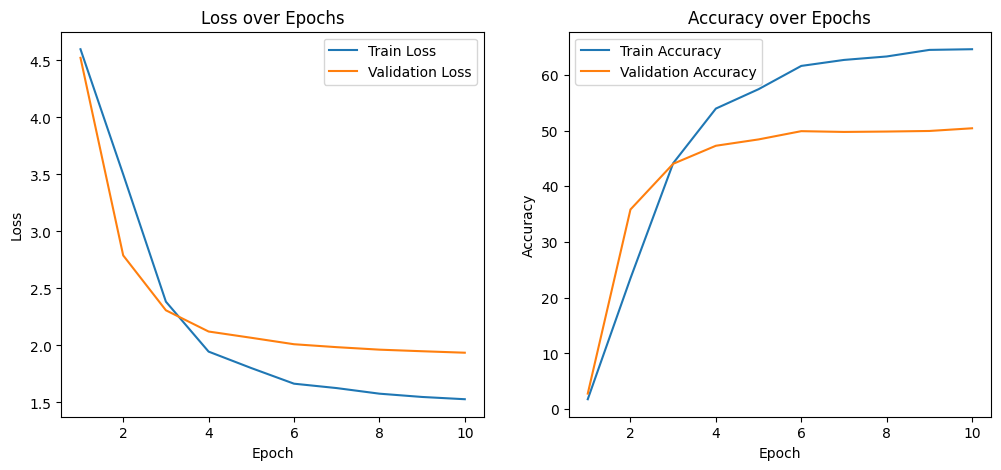

100%|██████████| 10/10 [02:53<00:00, 17.35s/it]

Epoch 10/10 | LR: 0.000316 | Train Loss: 1.5287, Train Acc: 64.60% | Val Loss: 1.9366, Val Acc: 50.41%


In [109]:
learn_model(model, train_loader, val_loader,10)

Выглядит как переобучение после 4 эпохи примерно (лоси расходяться кто куда)

In [24]:
#torch.save(model.state_dict(), 'mobile_no_aug.pth')

##### Densnet

In [50]:
head = nn.Sequential(
    nn.Linear(num_features_densnet, num_classes)
)

In [51]:
class Model(nn.Module):
    def __init__(self, backbone, head):
        super(Model, self).__init__()
        self.backbone = backbone.features #сначала все пропускаем через скелет, он выплевывает какое-то количество карт признаков 
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) #карты сжимаем до одного числа (те матрицы в скаляры)
        self.head = head

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1) #вытягивание в колбасу 
        x = self.head(x) #подаем в FCNN 
        return x

model = Model(backbone_densnet, head)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

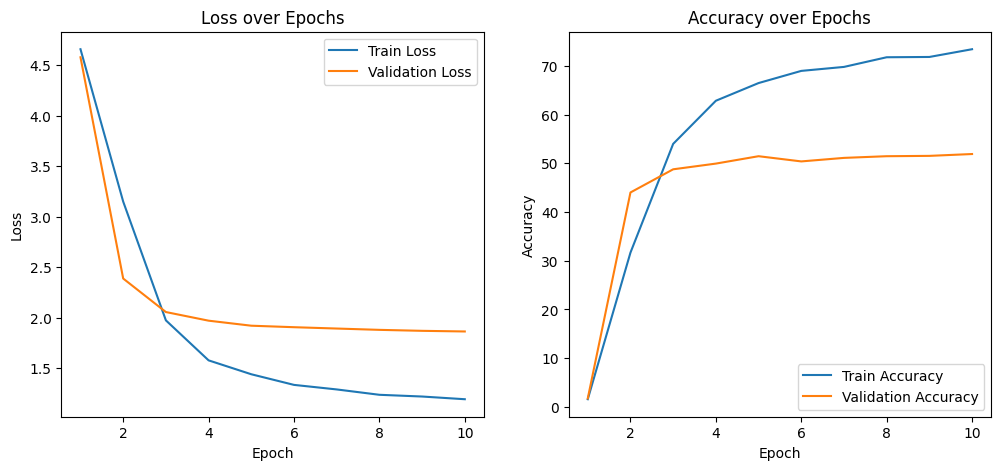

100%|██████████| 10/10 [04:37<00:00, 27.72s/it]

Epoch 10/10 | LR: 0.000316 | Train Loss: 1.1921, Train Acc: 73.41% | Val Loss: 1.8634, Val Acc: 51.90%


In [52]:
learn_model(model, train_loader, val_loader,10)

Тут тоже лоси подозрение на переобучение вызывают

In [29]:
#torch.save(model.state_dict(), 'densnet_no_aug.pth')

##### efficient 

In [110]:
head = nn.Sequential(
    nn.Linear(num_features_efficient, num_classes)
)

In [111]:
class Model(nn.Module):
    def __init__(self, backbone, head):
        super(Model, self).__init__()
        self.backbone = backbone.features #сначала все пропускаем через скелет, он выплевывает какое-то количество карт признаков 
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) #карты сжимаем до одного числа (те матрицы в скаляры)
        self.head = head

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1) #вытягивание в колбасу 
        x = self.head(x) #подаем в FCNN 
        return x

model = Model(backbone_efficient, head)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

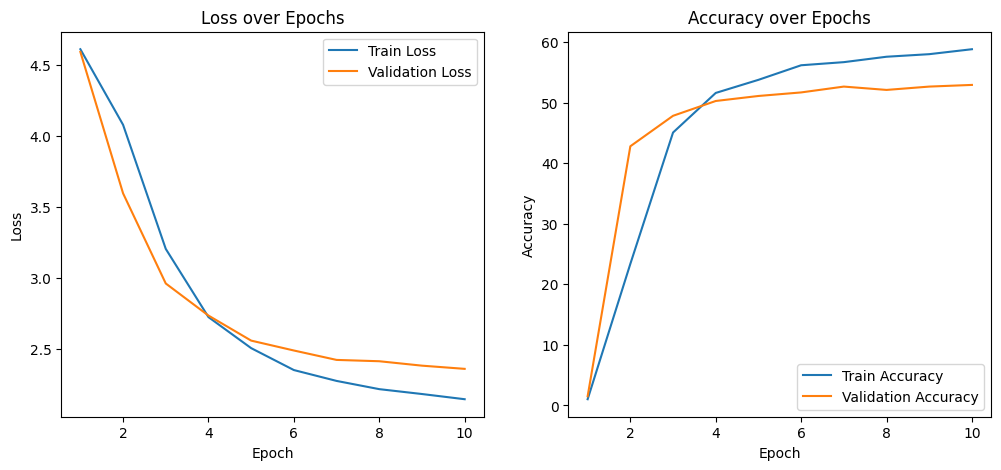

100%|██████████| 10/10 [03:31<00:00, 21.16s/it]

Epoch 10/10 | LR: 0.000316 | Train Loss: 2.1461, Train Acc: 58.82% | Val Loss: 2.3600, Val Acc: 52.93%


In [112]:
learn_model(model, train_loader, val_loader,10)

In [34]:
torch.save(model.state_dict(), 'efficient_no_aug.pth')

Церемония вручения медалей в номинации лучшая модель без аугментации объявляется открытой и так наши победители $*$ барабанная дробь $*$:

Первое место:efficientnet_b2 (Train Loss: 2.1461, Train Acc: 58.82% | Val Loss: 2.3600, Val Acc: 52.93%)

Второе место: densnet_121( Train Loss: 1.1921, Train Acc: 73.41% | Val Loss: 1.8634, Val Acc: 51.90%)

Третье место: mobile_v2 ( Train Loss: 1.5287, Train Acc: 64.60% | Val Loss: 1.9366, Val Acc: 50.41%)

efficientnet_b2 назначается победителем + она менее склонна к переобучению

Победитель может подойти и забрать свой приз в виде прохождения на следующий этап: Transfer learning с использованием аугментаций (простой/сложной)

#### Без transfer learning и без аугментации (только ресайз и нормализация)

In [111]:
class Model(nn.Module):
    def __init__(self, num_classes=100):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=0) #224x224x16
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=0) #224x224x32
        self.relu2 = nn.ReLU()
        
        self.max_pool1=nn.MaxPool2d(kernel_size=2,stride=2) # 112x112x32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=0) # 112x112x64
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=0)# 112x112x128
        self.bn1 = nn.BatchNorm2d(128)

        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.fc1 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        
        x = self.max_pool1(x)
        x = self.conv3(x)
        x = self.relu3(x)
        
        x = F.selu(self.bn1(self.conv4(x)))
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [112]:
train_dataset=My_Dataset(split='train', transform=train_transform_no_aug)
val_dataset=My_Dataset(split='val',transform=val_transform_no_aug)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(num_classes=100).to(device)

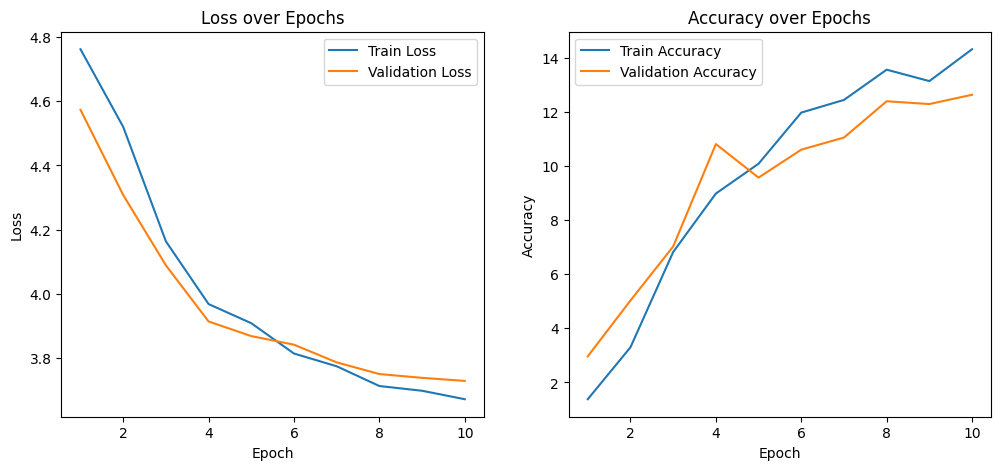

100%|██████████| 10/10 [04:26<00:00, 26.70s/it]

Epoch 10/10 | LR: 0.000316 | Train Loss: 3.6714, Train Acc: 14.33% | Val Loss: 3.7286, Val Acc: 12.65%


In [114]:
learn_model(model, train_loader, val_loader,10)

### 3. Простая и сложная агументация на модель с transfer learning и без

#### 3.1 Простая аугментация transfer learning - efficient (тк по итогам без аугментации выбрали её лучшей моделью)

In [113]:
train_transform_simple_aug = A.Compose([
    A.Resize(260,260,p=1),
    A.HorizontalFlip(p=0.7),
    A.VerticalFlip(p=0.1),
    A.Normalize(),
    ToTensorV2()
])

val_transform_simple_aug = A.Compose([
    A.Resize(260,260,p=1),
    A.Normalize(),
    ToTensorV2()
])

test_transform_simple_aug = A.Compose([
    A.Resize(260,260,p=1),
    A.Normalize(),
    ToTensorV2()
])

In [114]:
train_dataset=My_Dataset(split='train', transform=train_transform_simple_aug)
val_dataset=My_Dataset(split='val',transform=val_transform_simple_aug)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [115]:
head = nn.Sequential(
    nn.Linear(num_features_efficient, num_classes)
)

In [116]:
class Model(nn.Module):
    def __init__(self, backbone, head):
        super(Model, self).__init__()
        self.backbone = backbone.features 
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.head = head

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1) 
        x = self.head(x) 
        return x

model = Model(backbone_efficient, head)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

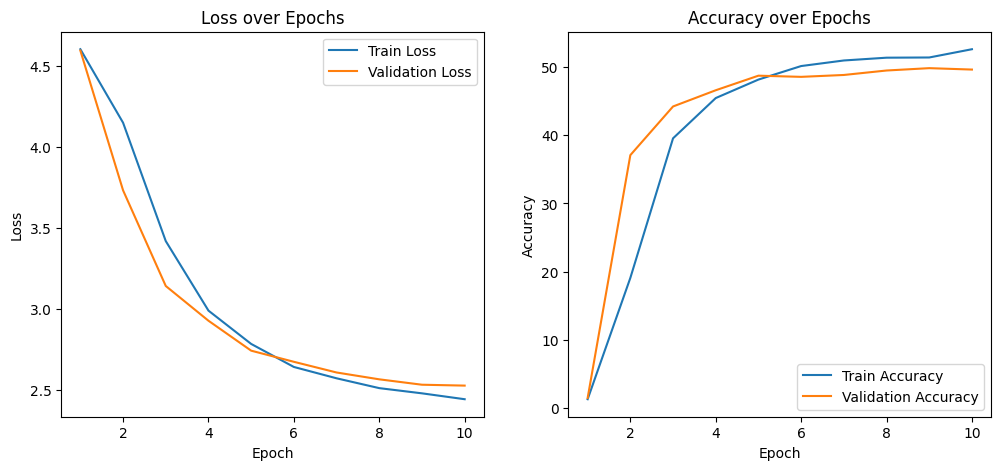

100%|██████████| 10/10 [04:56<00:00, 29.65s/it]

Epoch 10/10 | LR: 0.000316 | Train Loss: 2.4455, Train Acc: 52.60% | Val Loss: 2.5295, Val Acc: 49.62%


In [117]:
learn_model(model, train_loader, val_loader,10)

Есть склонность к отсутсвует и лосс более менее сходится 

#### 3.1 Простая аугментация без transfer learning


In [121]:
class Model(nn.Module):
    def __init__(self, num_classes=100):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=0) #32x32x16
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=0) #32x32x32
        self.relu2 = nn.ReLU()
        
        self.max_pool1=nn.MaxPool2d(kernel_size=2,stride=2) # 16x16x32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=0) # 16x16x64
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=0)# 16x16x128
        self.bn1 = nn.BatchNorm2d(128)

        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.fc1 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        
        x = self.max_pool1(x)
        x = self.conv3(x)
        x = self.relu3(x)
        
        x = F.selu(self.bn1(self.conv4(x)))
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [122]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(num_classes=100).to(device)

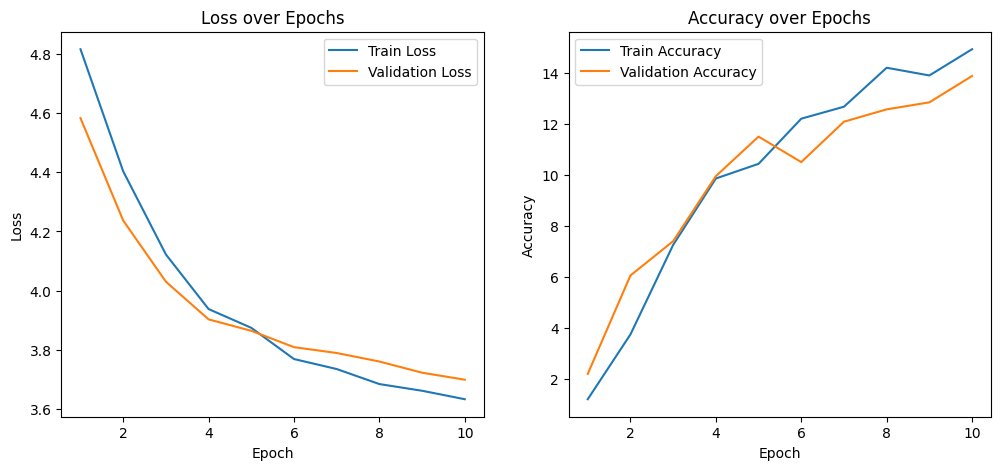

100%|██████████| 10/10 [04:22<00:00, 26.25s/it]

Epoch 10/10 | LR: 0.000316 | Train Loss: 3.6336, Train Acc: 14.94% | Val Loss: 3.6995, Val Acc: 13.89%


In [123]:
learn_model(model, train_loader, val_loader,10)

#### 3.2 Сложная аугментация с transfer learning efficient

In [118]:
train_transform_hard_aug = A.Compose([
    A.Resize(260,260,p=1),
    A.HorizontalFlip(p=0.7),
    A.VerticalFlip(p=0.1),
    A.RandomBrightnessContrast(p=0.6),
    
    #тут блок на играние с блюром и прочее
    A.OneOf([
         A.MedianBlur(p=0.5),
         A.GaussianBlur(p=0.5),
         A.GlassBlur(p=0.5),
         A.RandomGamma(p=0.05)
         ], p=0.5),
    
    #блок на поигрушки с цветами 
     A.OneOf([
          A.ToGray(p=0.2),
          A.RGBShift(p=0.2)
          ],p=0.5),
    
    A.PixelDropout(p=0.6),
    A.Normalize(),
    ToTensorV2()
])

val_transform_hard_aug = A.Compose([
    A.Resize(260,260,p=1),
    A.Normalize(),
    ToTensorV2()
])

test_transform_hard_aug = A.Compose([
    A.Resize(260,260,p=1),
    A.Normalize(),
    ToTensorV2()
])

In [119]:
train_dataset=My_Dataset(split='train',transform=train_transform_hard_aug)
val_dataset=My_Dataset(split='val',transform=val_transform_hard_aug)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [120]:
head = nn.Sequential(
    nn.Linear(num_features_efficient, num_classes)
)

In [121]:
class Model(nn.Module):
    def __init__(self, backbone, head):
        super(Model, self).__init__()
        self.backbone = backbone.features #сначала все пропускаем через скелет, он выплевывает какое-то количество карт признаков 
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) #карты сжимаем до одного числа (те матрицы в скаляры)
        self.head = head

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1) #вытягивание в колбасу 
        x = self.head(x) #подаем в FCNN 
        return x

model = Model(backbone_efficient, head)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

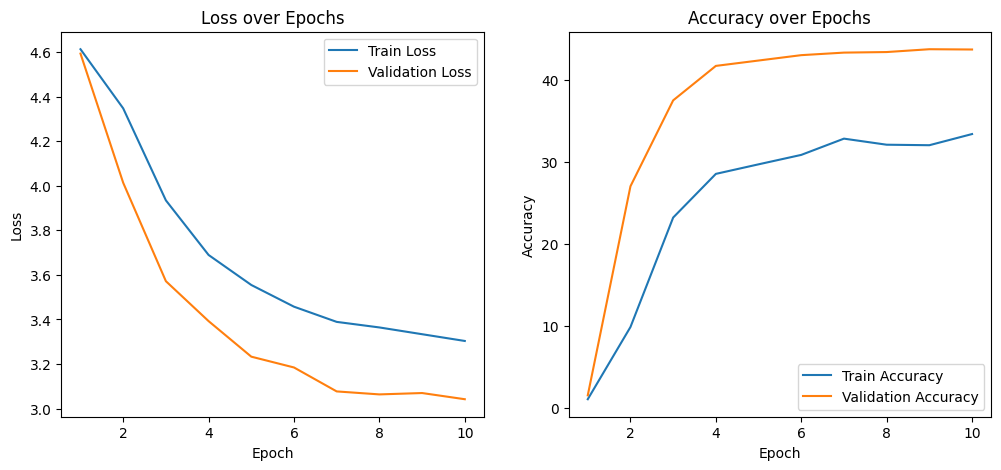

100%|██████████| 10/10 [09:56<00:00, 59.61s/it]

Epoch 10/10 | LR: 0.000316 | Train Loss: 3.3032, Train Acc: 33.38% | Val Loss: 3.0417, Val Acc: 43.69%


In [122]:
learn_model(model, train_loader, val_loader,10)

Переобучена 

#### 3.2 Сложная аугментация без transfer learning

In [129]:
class Model(nn.Module):
    def __init__(self, num_classes=100):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=0) #32x32x16
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=0) #32x32x32
        self.relu2 = nn.ReLU()
        
        self.max_pool1=nn.MaxPool2d(kernel_size=2,stride=2) # 16x16x32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=0) # 16x16x64
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=0)# 16x16x128
        self.bn1 = nn.BatchNorm2d(128)

        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.fc1 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        
        x = self.max_pool1(x)
        x = self.conv3(x)
        x = self.relu3(x)
        
        x = F.selu(self.bn1(self.conv4(x)))
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [130]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(num_classes=100).to(device)

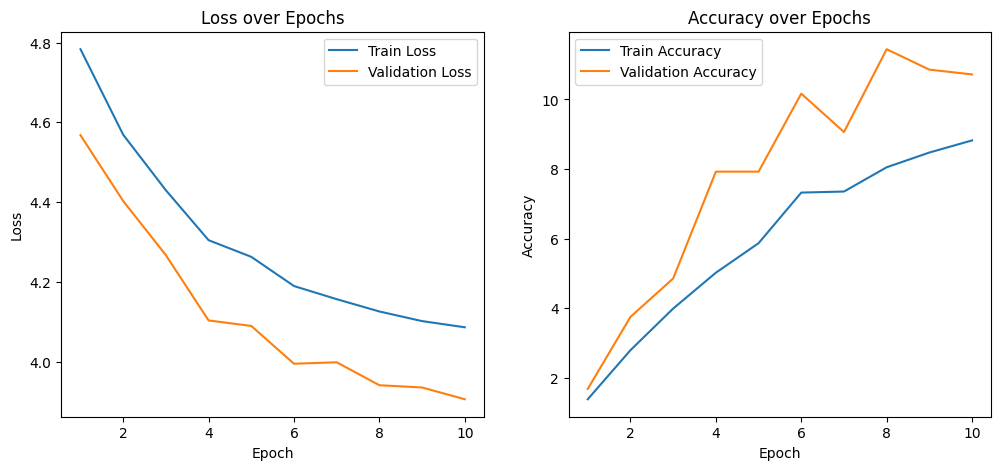

100%|██████████| 10/10 [08:18<00:00, 49.81s/it]

Epoch 10/10 | LR: 0.000316 | Train Loss: 4.0865, Train Acc: 8.82% | Val Loss: 3.9063, Val Acc: 10.72%


In [131]:
learn_model(model, train_loader, val_loader,10)

#### Попробуем упростить аугментацию и посмотрим на результаты, может быть мы слишком намудрили тк модель с transfer learning и сложной аугментацией сильно переобучается 

In [225]:
train_transform_easy_aug = A.Compose([
    A.Resize(260,260,p=1),
    A.HorizontalFlip(p=0.7),
    A.VerticalFlip(p=0.1),
    A.PixelDropout(p=0.6),
    A.Normalize(),
    ToTensorV2()
])

val_transform_easy_aug = A.Compose([
    A.Resize(260,260,p=1),
    A.Normalize(),
    ToTensorV2()
])

test_transform_easy_aug = A.Compose([
    A.Resize(260,260,p=1),
    A.Normalize(),
    ToTensorV2()
])

In [226]:
train_dataset=My_Dataset(split='train', transform=train_transform_easy_aug)
val_dataset=My_Dataset(split='val',transform=val_transform_easy_aug)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [227]:
head = nn.Sequential(
    nn.Linear(num_features_efficient, num_classes)
)
class Model(nn.Module):
    def __init__(self, backbone, head):
        super(Model, self).__init__()
        self.backbone = backbone.features #сначала все пропускаем через скелет, он выплевывает какое-то количество карт признаков 
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) #карты сжимаем до одного числа (те матрицы в скаляры)
        self.head = head

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1) #вытягивание в колбасу 
        x = self.head(x) #подаем в FCNN 
        return x

model = Model(backbone_efficient, head)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

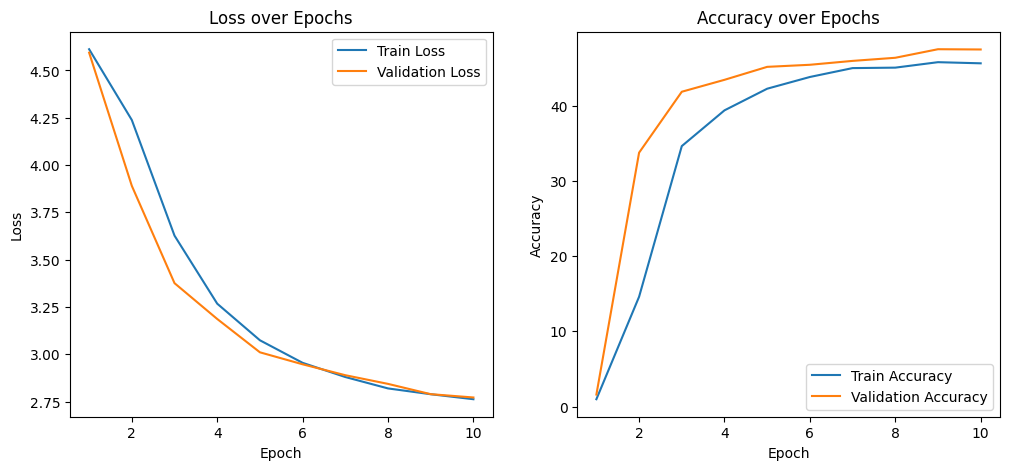

100%|██████████| 10/10 [06:30<00:00, 39.05s/it]

Epoch 10/10 | LR: 0.000316 | Train Loss: 2.7631, Train Acc: 45.61% | Val Loss: 2.7723, Val Acc: 47.45%


In [228]:
learn_model(model, train_loader, val_loader,10)

Уже лучше, избавились от переобучения

### 4. Upscale для модели с transfer learning + упрощенная аугментация 

Переделаем датасет так чтобы он выдавал нам уже апскейленные изображенные, которые потом будут проходить через аугментацию и подаваться на вход нашей модели с transfer learning: upscale пробуем ближайшие соседи, биллинейный, бикубический

In [280]:
class testdata_upscale(Dataset):
    def __init__(self,transform=None, root_dir="content/data/test",upscale=None,size=260):
        self.size=size
        self.upscale=upscale
        self.transform = transform
        self.root_dir=root_dir
        self.images=sorted(os.listdir(self.root_dir)[:-1], key=lambda x: int(x.split('.')[0]))
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx): 
        img_path = os.path.join(self.root_dir,self.images[idx]) 
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.upscale=='nearest':
            image = cv2.resize(image, (self.size,self.size), interpolation=cv2.INTER_NEAREST)
        elif self.upscale=='bilinear':
            image = cv2.resize(image, (self.size,self.size), interpolation=cv2.INTER_LINEAR)
        elif self.upscale=='bicubic':
            image = cv2.resize(image, (self.size,self.size), interpolation=cv2.INTER_CUBIC)
            
        if self.transform: #подаём аугументацию
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

In [281]:
class My_Dataset_upscale(Dataset):
    def __init__(self, split='train', transform=None, root_dir="content/data/",upscale=None,size=224):
        self.size=size
        self.transform = transform
        self.samples = []
        self.upscale=upscale
        # пути к файлам тест и трейн
        files_train =os.path.join(root_dir,'train')
        classes = os.listdir(files_train)
        
        def split_files(files, split):
            n = len(files) #сколько всего картинок внутри класса 
            if split == 'train':
                return files[:int(0.7 * n)]
            elif split == 'val':
                return files[int(0.7 * n):]
            else:
                return files
                
        #train->class-> деление  на трейн и валидацию 
        for class_name in classes:
            class_dir = os.path.join(files_train,class_name) #заходим в train и затем в конкретный класс
            class_files= os.listdir(class_dir) #все файлы внутри одного класса 
            # нужно поделить все файлы внутри одного класса на trein и валидацию
            class_split=split_files(class_files,split)
            #поставили метку для каждого файла внутри класса 
            for file in class_split:
                self.samples.append((os.path.join(class_dir,file),int(class_name)))
 
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx): 
        img_path, label = self.samples[idx]  #внутри батча берем название файлика и его лейбл 
        image = cv2.imread(img_path) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.upscale=='nearest':
            image = cv2.resize(image, (self.size,self.size), interpolation=cv2.INTER_NEAREST)
        elif self.upscale=='bilinear':
            image = cv2.resize(image, (self.size,self.size), interpolation=cv2.INTER_LINEAR)
        elif self.upscale=='bicubic':
            image = cv2.resize(image, (self.size,self.size), interpolation=cv2.INTER_CUBIC)
        else:
            image=image

        
        if image is None:
          print(f"Не открывается {img_path}")
          new_idx = (idx + 1) % len(self.samples)
          return self.__getitem__(new_idx)

        if self.transform: #подаём аугументацию
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image, label

In [282]:
train_transform_upscale = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.PixelDropout(p=0.4),
    A.Normalize(),
    ToTensorV2()
])

val_transform_upscale = A.Compose([
    A.Normalize(),
    ToTensorV2()
])

test_transform_upscale = A.Compose([
    A.Normalize(),
    ToTensorV2()
])

In [283]:
train_dataset=My_Dataset_upscale(split='train',upscale='bicubic',transform=train_transform_upscale)
val_dataset=My_Dataset_upscale(split='val',upscale='bicubic',transform=val_transform_upscale)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [284]:
head = nn.Sequential(
    nn.Linear(num_features_efficient, num_classes)
)
class Model(nn.Module):
    def __init__(self, backbone, head):
        super(Model, self).__init__()
        self.backbone = backbone.features #сначала все пропускаем через скелет, он выплевывает какое-то количество карт признаков 
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) #карты сжимаем до одного числа (те матрицы в скаляры)
        self.head = head

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1) #вытягивание в колбасу 
        x = self.head(x) #подаем в FCNN 
        return x

model = Model(backbone_efficient, head)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

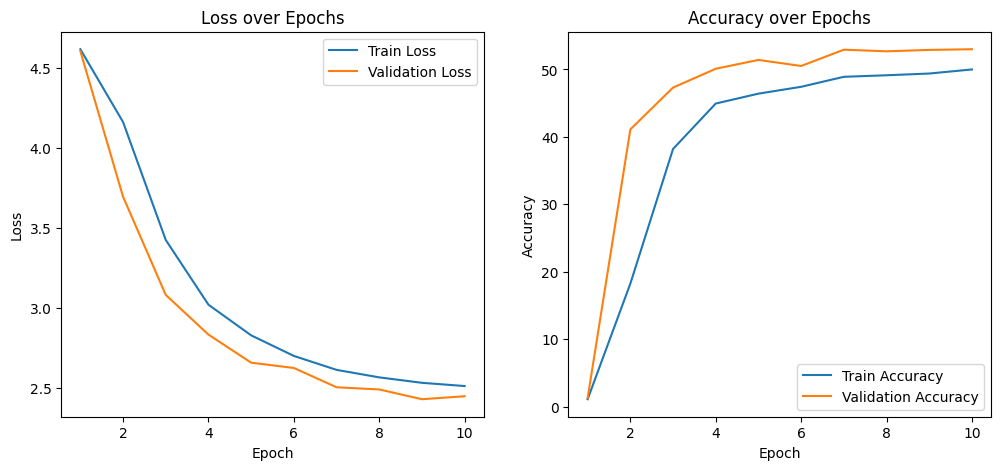

100%|██████████| 10/10 [04:25<00:00, 26.51s/it]

Epoch 10/10 | LR: 0.000316 | Train Loss: 2.5134, Train Acc: 50.00% | Val Loss: 2.4497, Val Acc: 53.00%
EarlyStopping counter: 1 out of 2


In [287]:
learn_model(model, train_loader,val_loader,10)

Прогнали с bicubic upscale результат на тесте улучшился

### 5. Аугментация на валидационных данных 

(перед тем как получать результат модельки на тесте, мы тестовою картинку N раз прогоняем через
аугументацию и выходы усредняем и потом усредненные выходы используем как итоговое предсказание  )

In [239]:
val_transform_upscale = A.Compose([
    A.HorizontalFlip(p=0.7),
    A.VerticalFlip(p=0.1),
    A.PixelDropout(p=0.6),
    A.Normalize(),
    ToTensorV2(),
])

In [240]:
val_dataset=My_Dataset_upscale(split='val',upscale='bicubic',transform=val_transform_upscale)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [241]:
head = nn.Sequential(
    nn.Linear(num_features_efficient, num_classes)
)
class Model(nn.Module):
    def __init__(self, backbone, head):
        super(Model, self).__init__()
        self.backbone = backbone.features  
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.head = head

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  
        x = self.head(x)  
        return x

model = Model(backbone_efficient, head)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [243]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
    
criterion = nn.CrossEntropyLoss()
optimizer =optim.Adam(model.parameters(), lr=0.001)
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
early_stopping_optimizer_switch = EarlyStopping(patience=2, verbose=True)

warmup_epochs = 2
optimizer_switched = False
base_lr = 0.001
num_epochs = 10


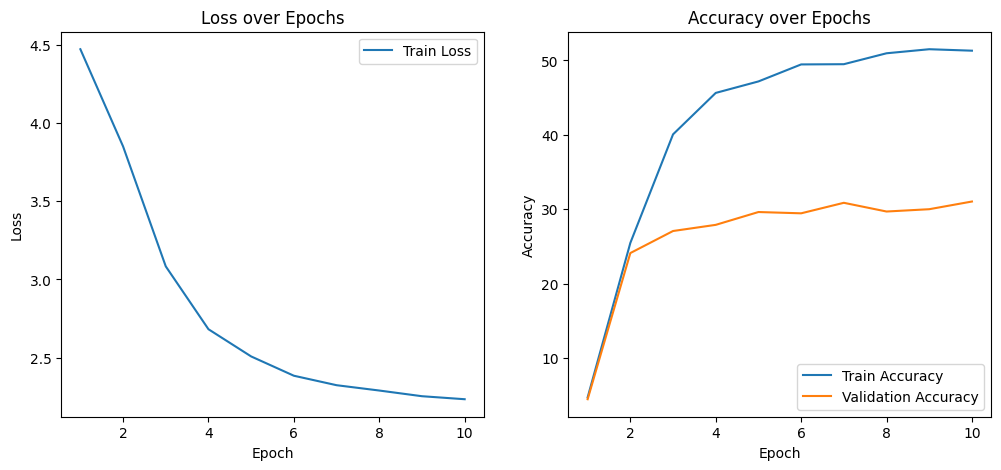

100%|██████████| 10/10 [07:39<00:00, 45.98s/it]

Epoch 10/10 | LR: 0.000034 | Train Loss: 2.2351, Train Acc: 51.32% | Val Acc: 31.05%


In [244]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-4)
    else: # вне вормапа обнавляем все по шедулеру такому 
        scheduler_step.step()
        
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets= targets.long().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total,pred = 0.0, 0, 0,0
    n=4 #те 3 раза прогоняем батч через аугментацию и смотрим на рещультаты 
    with torch.no_grad():
        for _ in range(n):
            predicted=np.array([])
            batch_targets=np.array([])
            for inputs, targets in val_loader:
                    batch_targets=np.append(batch_targets,targets)   
                    inputs, targets = inputs.to(device), targets.long().to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    
                    running_val_loss += loss.item() * inputs.size(0)
                    _, predicted_values = outputs.max(1)
                    predicted=np.append(predicted,predicted_values.cpu().numpy())
                    
            pred+=predicted
        last_pred=pred/n    
        correct += torch.from_numpy(np.round(last_pred)).eq(torch.from_numpy(batch_targets)).sum().item()
    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = 100. * correct / len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

## Часть 4 Генератор

In [14]:
num_classes = 100
latent_dim = 150


In [15]:
train_transform = A.Compose([
    A.Normalize(),
    ToTensorV2()
])

In [18]:
dataset=My_Dataset(split=None,transform=train_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [19]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=100, feature_map_size=64, channels=3):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        input_dim = latent_dim + num_classes
        
        self.model = nn.Sequential(

            nn.ConvTranspose2d(input_dim, feature_map_size * 8, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map_size * 2, feature_map_size, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map_size, channels, 3, stride=1, padding=1, bias=False),
            nn.Tanh() 
        )
    
    def forward(self, noise, labels):

        label_onehot = F.one_hot(labels, num_classes=self.num_classes).float() 

        gen_input = torch.cat([noise, label_onehot], dim=1)
        gen_input = gen_input.view(gen_input.size(0), gen_input.size(1), 1, 1)
        return self.model(gen_input)

In [20]:
class Discriminator(nn.Module):
    def __init__(self, feature_map_size=64, channels=3, num_classes=100):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes

        self.model = nn.Sequential(
            nn.Conv2d(channels + num_classes, feature_map_size, 4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size, feature_map_size * 2, 4,stride= 2,  padding=1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4,stride= 2, padding= 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 3, stride=1,  padding=1, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, img, labels):

        label_onehot = F.one_hot(labels, num_classes=self.num_classes).float()
        label_map = label_onehot.unsqueeze(2).unsqueeze(3) 
        label_map = label_map.expand(-1, -1, img.size(2), img.size(3))
        
        conditioned_input = torch.cat([img, label_map], dim=1)
        out = self.model(conditioned_input)
        return out.view(-1)


In [21]:
from torch.optim.lr_scheduler import StepLR
num_classes = 100
latent_dim = 150
lr = 0.0001
n_discriminator = 1
n_generator = 12
num_epochs = 25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator(latent_dim=latent_dim, num_classes=num_classes).to(device)
D = Discriminator(num_classes=num_classes).to(device)

real_label = 1.
fake_label = 0.

optimizer_D = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_G = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))

scheduler_G = StepLR(optimizer_G, step_size=25, gamma=0.1)
scheduler_D = StepLR(optimizer_D, step_size=25, gamma=0.1)

losses_G = []
losses_D = []
criterion = nn.BCELoss()


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/25] Batch 0/298  Loss_D: 1.3633  Loss_G: 0.1061
Epoch [1/25] Batch 50/298  Loss_D: 1.7264  Loss_G: 0.4831
Epoch [1/25] Batch 100/298  Loss_D: 1.0038  Loss_G: 0.8541
Epoch [1/25] Batch 150/298  Loss_D: 0.6130  Loss_G: 1.0959
Epoch [1/25] Batch 200/298  Loss_D: 0.5061  Loss_G: 0.9400
Epoch [1/25] Batch 250/298  Loss_D: 0.6930  Loss_G: 3.2254


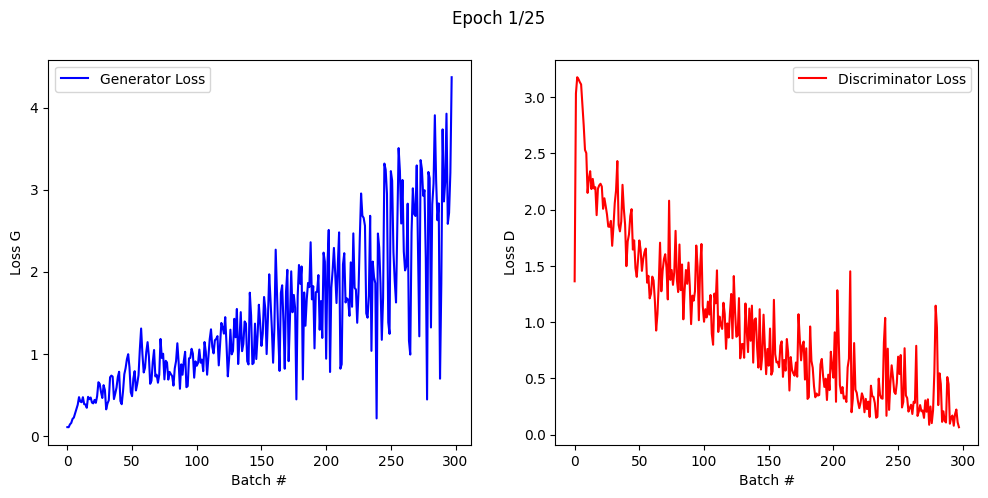

  4%|▍         | 1/25 [00:25<10:18, 25.75s/it]

Epoch [2/25] Batch 0/298  Loss_D: 0.2336  Loss_G: 2.6091
Epoch [2/25] Batch 50/298  Loss_D: 0.1357  Loss_G: 3.6011
Epoch [2/25] Batch 100/298  Loss_D: 0.0921  Loss_G: 3.2609
Epoch [2/25] Batch 150/298  Loss_D: 0.0157  Loss_G: 4.5505
Epoch [2/25] Batch 200/298  Loss_D: 0.0380  Loss_G: 5.9042
Epoch [2/25] Batch 250/298  Loss_D: 0.6064  Loss_G: 0.3528


<Figure size 640x480 with 0 Axes>

  8%|▊         | 2/25 [00:48<09:07, 23.79s/it]

Epoch [3/25] Batch 0/298  Loss_D: 0.0378  Loss_G: 4.5356
Epoch [3/25] Batch 50/298  Loss_D: 0.1868  Loss_G: 4.2200
Epoch [3/25] Batch 100/298  Loss_D: 0.0244  Loss_G: 3.0427
Epoch [3/25] Batch 150/298  Loss_D: 0.0025  Loss_G: 5.0868
Epoch [3/25] Batch 200/298  Loss_D: 0.0048  Loss_G: 5.6443
Epoch [3/25] Batch 250/298  Loss_D: 0.0016  Loss_G: 6.5381


<Figure size 640x480 with 0 Axes>

 12%|█▏        | 3/25 [01:10<08:29, 23.18s/it]

Epoch [4/25] Batch 0/298  Loss_D: 0.0203  Loss_G: 9.4675
Epoch [4/25] Batch 50/298  Loss_D: 0.3188  Loss_G: 5.5345
Epoch [4/25] Batch 100/298  Loss_D: 0.0043  Loss_G: 5.9883
Epoch [4/25] Batch 150/298  Loss_D: 0.0153  Loss_G: 4.6156
Epoch [4/25] Batch 200/298  Loss_D: 0.0231  Loss_G: 6.9855
Epoch [4/25] Batch 250/298  Loss_D: 0.0021  Loss_G: 6.1683


<Figure size 640x480 with 0 Axes>

 16%|█▌        | 4/25 [01:32<07:55, 22.65s/it]

Epoch [5/25] Batch 0/298  Loss_D: 0.0015  Loss_G: 5.7703
Epoch [5/25] Batch 50/298  Loss_D: 0.0022  Loss_G: 7.2905
Epoch [5/25] Batch 100/298  Loss_D: 0.0008  Loss_G: 5.5999
Epoch [5/25] Batch 150/298  Loss_D: 0.0020  Loss_G: 5.9234
Epoch [5/25] Batch 200/298  Loss_D: 0.0009  Loss_G: 7.0142
Epoch [5/25] Batch 250/298  Loss_D: 0.0006  Loss_G: 6.8234


<Figure size 640x480 with 0 Axes>

 20%|██        | 5/25 [01:54<07:25, 22.29s/it]

Epoch [6/25] Batch 0/298  Loss_D: 0.0005  Loss_G: 8.7003
Epoch [6/25] Batch 50/298  Loss_D: 0.0173  Loss_G: 7.1307
Epoch [6/25] Batch 100/298  Loss_D: 0.0022  Loss_G: 7.7134
Epoch [6/25] Batch 150/298  Loss_D: 0.0024  Loss_G: 5.1908
Epoch [6/25] Batch 200/298  Loss_D: 0.0433  Loss_G: 7.7652
Epoch [6/25] Batch 250/298  Loss_D: 0.0166  Loss_G: 6.1882


<Figure size 640x480 with 0 Axes>

 24%|██▍       | 6/25 [02:15<06:57, 21.99s/it]

Epoch [7/25] Batch 0/298  Loss_D: 0.0263  Loss_G: 3.8966
Epoch [7/25] Batch 50/298  Loss_D: 0.0122  Loss_G: 7.6632
Epoch [7/25] Batch 100/298  Loss_D: 0.0025  Loss_G: 7.9749
Epoch [7/25] Batch 150/298  Loss_D: 0.0014  Loss_G: 7.8379
Epoch [7/25] Batch 200/298  Loss_D: 0.0014  Loss_G: 7.2937
Epoch [7/25] Batch 250/298  Loss_D: 0.0035  Loss_G: 6.7363


<Figure size 640x480 with 0 Axes>

 28%|██▊       | 7/25 [02:36<06:31, 21.74s/it]

Epoch [8/25] Batch 0/298  Loss_D: 0.0011  Loss_G: 7.6600
Epoch [8/25] Batch 50/298  Loss_D: 0.0011  Loss_G: 7.2863
Epoch [8/25] Batch 100/298  Loss_D: 0.0037  Loss_G: 6.5937
Epoch [8/25] Batch 150/298  Loss_D: 0.0009  Loss_G: 6.6245
Epoch [8/25] Batch 200/298  Loss_D: 0.0040  Loss_G: 8.8323
Epoch [8/25] Batch 250/298  Loss_D: 0.0007  Loss_G: 7.8140


<Figure size 640x480 with 0 Axes>

 32%|███▏      | 8/25 [02:57<06:05, 21.49s/it]

Epoch [9/25] Batch 0/298  Loss_D: 0.0001  Loss_G: 7.8586
Epoch [9/25] Batch 50/298  Loss_D: 0.0008  Loss_G: 6.1018
Epoch [9/25] Batch 100/298  Loss_D: 0.0002  Loss_G: 7.7869
Epoch [9/25] Batch 150/298  Loss_D: 0.0001  Loss_G: 9.5526
Epoch [9/25] Batch 200/298  Loss_D: 0.0008  Loss_G: 6.0739
Epoch [9/25] Batch 250/298  Loss_D: 0.0004  Loss_G: 8.5287


<Figure size 640x480 with 0 Axes>

 36%|███▌      | 9/25 [03:18<05:40, 21.27s/it]

Epoch [10/25] Batch 0/298  Loss_D: 0.0005  Loss_G: 9.6010
Epoch [10/25] Batch 50/298  Loss_D: 0.0012  Loss_G: 9.3443
Epoch [10/25] Batch 100/298  Loss_D: 0.0001  Loss_G: 7.4367
Epoch [10/25] Batch 150/298  Loss_D: 0.0001  Loss_G: 9.3980
Epoch [10/25] Batch 200/298  Loss_D: 0.0003  Loss_G: 8.7225
Epoch [10/25] Batch 250/298  Loss_D: 0.0003  Loss_G: 9.1734


<Figure size 640x480 with 0 Axes>

 40%|████      | 10/25 [03:39<05:16, 21.07s/it]

Epoch [11/25] Batch 0/298  Loss_D: 0.0010  Loss_G: 10.5028
Epoch [11/25] Batch 50/298  Loss_D: 0.0005  Loss_G: 8.5266
Epoch [11/25] Batch 100/298  Loss_D: 0.0001  Loss_G: 8.5525
Epoch [11/25] Batch 150/298  Loss_D: 0.0005  Loss_G: 9.1915
Epoch [11/25] Batch 200/298  Loss_D: 0.0005  Loss_G: 6.7148
Epoch [11/25] Batch 250/298  Loss_D: 0.0002  Loss_G: 7.3880


<Figure size 640x480 with 0 Axes>

 44%|████▍     | 11/25 [03:59<04:52, 20.90s/it]

Epoch [12/25] Batch 0/298  Loss_D: 0.0001  Loss_G: 10.2471
Epoch [12/25] Batch 50/298  Loss_D: 0.0003  Loss_G: 8.7015
Epoch [12/25] Batch 100/298  Loss_D: 0.0004  Loss_G: 8.3311
Epoch [12/25] Batch 150/298  Loss_D: 0.0003  Loss_G: 8.2437
Epoch [12/25] Batch 200/298  Loss_D: 0.0001  Loss_G: 9.9583
Epoch [12/25] Batch 250/298  Loss_D: 0.0001  Loss_G: 9.0651


<Figure size 640x480 with 0 Axes>

 48%|████▊     | 12/25 [04:19<04:29, 20.74s/it]

Epoch [13/25] Batch 0/298  Loss_D: 0.0002  Loss_G: 10.2652
Epoch [13/25] Batch 50/298  Loss_D: 0.0003  Loss_G: 9.8418
Epoch [13/25] Batch 100/298  Loss_D: 0.0006  Loss_G: 10.4397
Epoch [13/25] Batch 150/298  Loss_D: 0.0001  Loss_G: 8.7341
Epoch [13/25] Batch 200/298  Loss_D: 0.0002  Loss_G: 11.6264
Epoch [13/25] Batch 250/298  Loss_D: 0.0001  Loss_G: 9.7562


<Figure size 640x480 with 0 Axes>

 52%|█████▏    | 13/25 [04:40<04:07, 20.60s/it]

Epoch [14/25] Batch 0/298  Loss_D: 0.0001  Loss_G: 10.8026
Epoch [14/25] Batch 50/298  Loss_D: 0.0000  Loss_G: 9.3624
Epoch [14/25] Batch 100/298  Loss_D: 0.0001  Loss_G: 11.4268
Epoch [14/25] Batch 150/298  Loss_D: 0.0009  Loss_G: 9.5194
Epoch [14/25] Batch 200/298  Loss_D: 0.0001  Loss_G: 11.4756
Epoch [14/25] Batch 250/298  Loss_D: 0.0012  Loss_G: 11.1235


<Figure size 640x480 with 0 Axes>

 56%|█████▌    | 14/25 [05:00<03:45, 20.47s/it]

Epoch [15/25] Batch 0/298  Loss_D: 12.0793  Loss_G: 0.6863
Epoch [15/25] Batch 50/298  Loss_D: 0.4739  Loss_G: 3.5545
Epoch [15/25] Batch 100/298  Loss_D: 0.0074  Loss_G: 6.3024
Epoch [15/25] Batch 150/298  Loss_D: 0.0133  Loss_G: 6.2306
Epoch [15/25] Batch 200/298  Loss_D: 0.0093  Loss_G: 6.6855
Epoch [15/25] Batch 250/298  Loss_D: 0.0006  Loss_G: 5.9319


<Figure size 640x480 with 0 Axes>

 60%|██████    | 15/25 [05:20<03:23, 20.32s/it]

Epoch [16/25] Batch 0/298  Loss_D: 0.0019  Loss_G: 6.7022
Epoch [16/25] Batch 50/298  Loss_D: 0.0029  Loss_G: 4.0528
Epoch [16/25] Batch 100/298  Loss_D: 0.0023  Loss_G: 6.3950
Epoch [16/25] Batch 150/298  Loss_D: 0.0004  Loss_G: 8.3752
Epoch [16/25] Batch 200/298  Loss_D: 0.0004  Loss_G: 6.7082
Epoch [16/25] Batch 250/298  Loss_D: 0.0006  Loss_G: 7.7181


<Figure size 640x480 with 0 Axes>

 64%|██████▍   | 16/25 [05:40<03:01, 20.20s/it]

Epoch [17/25] Batch 0/298  Loss_D: 0.0002  Loss_G: 8.3287
Epoch [17/25] Batch 50/298  Loss_D: 0.0003  Loss_G: 8.9627
Epoch [17/25] Batch 100/298  Loss_D: 0.0005  Loss_G: 7.7195
Epoch [17/25] Batch 150/298  Loss_D: 0.0002  Loss_G: 8.6146
Epoch [17/25] Batch 200/298  Loss_D: 0.0008  Loss_G: 7.5966
Epoch [17/25] Batch 250/298  Loss_D: 0.0003  Loss_G: 8.5255


<Figure size 640x480 with 0 Axes>

 68%|██████▊   | 17/25 [06:00<02:40, 20.09s/it]

Epoch [18/25] Batch 0/298  Loss_D: 0.0003  Loss_G: 6.3952
Epoch [18/25] Batch 50/298  Loss_D: 0.0002  Loss_G: 10.5870
Epoch [18/25] Batch 100/298  Loss_D: 0.0009  Loss_G: 9.8985
Epoch [18/25] Batch 150/298  Loss_D: 0.0004  Loss_G: 7.3260
Epoch [18/25] Batch 200/298  Loss_D: 0.0005  Loss_G: 9.4623
Epoch [18/25] Batch 250/298  Loss_D: 0.0001  Loss_G: 7.6973


<Figure size 640x480 with 0 Axes>

 72%|███████▏  | 18/25 [06:20<02:20, 20.07s/it]

Epoch [19/25] Batch 0/298  Loss_D: 0.0001  Loss_G: 7.4908
Epoch [19/25] Batch 50/298  Loss_D: 0.0002  Loss_G: 8.6987
Epoch [19/25] Batch 100/298  Loss_D: 0.0013  Loss_G: 9.0041
Epoch [19/25] Batch 150/298  Loss_D: 0.0002  Loss_G: 8.7268
Epoch [19/25] Batch 200/298  Loss_D: 0.0001  Loss_G: 9.8561
Epoch [19/25] Batch 250/298  Loss_D: 0.0001  Loss_G: 8.7483


<Figure size 640x480 with 0 Axes>

 76%|███████▌  | 19/25 [06:40<01:59, 19.99s/it]

Epoch [20/25] Batch 0/298  Loss_D: 2.5033  Loss_G: 0.0214
Epoch [20/25] Batch 50/298  Loss_D: 0.0072  Loss_G: 7.8168
Epoch [20/25] Batch 100/298  Loss_D: 0.0105  Loss_G: 5.3298
Epoch [20/25] Batch 150/298  Loss_D: 0.0013  Loss_G: 7.5273
Epoch [20/25] Batch 200/298  Loss_D: 0.0006  Loss_G: 7.6998
Epoch [20/25] Batch 250/298  Loss_D: 0.0023  Loss_G: 4.5790


<Figure size 640x480 with 0 Axes>

 80%|████████  | 20/25 [06:59<01:39, 19.94s/it]

Epoch [21/25] Batch 0/298  Loss_D: 0.0028  Loss_G: 6.5096
Epoch [21/25] Batch 50/298  Loss_D: 0.0014  Loss_G: 8.3404
Epoch [21/25] Batch 100/298  Loss_D: 0.0018  Loss_G: 8.1487
Epoch [21/25] Batch 150/298  Loss_D: 0.0012  Loss_G: 8.2829
Epoch [21/25] Batch 200/298  Loss_D: 0.0006  Loss_G: 8.0337
Epoch [21/25] Batch 250/298  Loss_D: 0.0006  Loss_G: 7.3643


<Figure size 640x480 with 0 Axes>

 84%|████████▍ | 21/25 [07:19<01:19, 19.85s/it]

Epoch [22/25] Batch 0/298  Loss_D: 0.0510  Loss_G: 12.6951
Epoch [22/25] Batch 50/298  Loss_D: 0.0012  Loss_G: 9.0372
Epoch [22/25] Batch 100/298  Loss_D: 0.0008  Loss_G: 9.4196
Epoch [22/25] Batch 150/298  Loss_D: 0.0011  Loss_G: 9.1815
Epoch [22/25] Batch 200/298  Loss_D: 0.0012  Loss_G: 8.7353
Epoch [22/25] Batch 250/298  Loss_D: 0.0008  Loss_G: 7.2020


<Figure size 640x480 with 0 Axes>

 88%|████████▊ | 22/25 [07:39<00:59, 19.77s/it]

Epoch [23/25] Batch 0/298  Loss_D: 0.0123  Loss_G: 0.4489
Epoch [23/25] Batch 50/298  Loss_D: 0.0008  Loss_G: 6.7245
Epoch [23/25] Batch 100/298  Loss_D: 0.0007  Loss_G: 9.6990
Epoch [23/25] Batch 150/298  Loss_D: 0.0018  Loss_G: 6.6230
Epoch [23/25] Batch 200/298  Loss_D: 0.0021  Loss_G: 8.5938
Epoch [23/25] Batch 250/298  Loss_D: 0.0009  Loss_G: 9.4305


<Figure size 640x480 with 0 Axes>

 92%|█████████▏| 23/25 [07:58<00:39, 19.71s/it]

Epoch [24/25] Batch 0/298  Loss_D: 0.0446  Loss_G: 12.3395
Epoch [24/25] Batch 50/298  Loss_D: 0.0036  Loss_G: 7.0924
Epoch [24/25] Batch 100/298  Loss_D: 0.0029  Loss_G: 8.6386
Epoch [24/25] Batch 150/298  Loss_D: 0.0012  Loss_G: 8.8306
Epoch [24/25] Batch 200/298  Loss_D: 0.0003  Loss_G: 9.5878
Epoch [24/25] Batch 250/298  Loss_D: 0.0002  Loss_G: 8.9085


<Figure size 640x480 with 0 Axes>

 96%|█████████▌| 24/25 [08:18<00:19, 19.64s/it]

Epoch [25/25] Batch 0/298  Loss_D: 0.0048  Loss_G: 2.3597
Epoch [25/25] Batch 50/298  Loss_D: 0.0012  Loss_G: 8.3154
Epoch [25/25] Batch 100/298  Loss_D: 0.0002  Loss_G: 7.1515
Epoch [25/25] Batch 150/298  Loss_D: 0.0005  Loss_G: 8.9355
Epoch [25/25] Batch 200/298  Loss_D: 0.0051  Loss_G: 8.2149
Epoch [25/25] Batch 250/298  Loss_D: 0.0002  Loss_G: 9.2108


<Figure size 640x480 with 0 Axes>

100%|██████████| 25/25 [08:37<00:00, 20.71s/it]


In [22]:
plt.ion() 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for epoch in tqdm(range(num_epochs)):
    for i, (real_images, real_labels) in enumerate(dataloader):
        real_images = real_images.to(device)
        real_labels = real_labels.to(device)
        batch_size_curr = real_images.size(0)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        for _ in range(n_discriminator):
            optimizer_D.zero_grad()

            labels_real = torch.full((batch_size_curr,), real_label, device=device)
            output_real = D(real_images, real_labels).view(-1)
            loss_D_real = criterion(output_real, labels_real)
            loss_D_real.backward()

            noise = torch.randn(batch_size_curr, latent_dim, device=device)
            fake_labels = torch.randint(0, num_classes, (batch_size_curr,), device=device)
            fake_images = G(noise, fake_labels)
            labels_fake = torch.full((batch_size_curr,), fake_label, device=device)
            output_fake = D(fake_images.detach(), fake_labels).view(-1)
            loss_D_fake = criterion(output_fake, labels_fake)
            loss_D_fake.backward()

            loss_D = loss_D_real + loss_D_fake
            optimizer_D.step()

        losses_D.append(loss_D.item())

        # ---------------------
        #  Train Generator
        # ---------------------
        for _ in range(n_generator):
            optimizer_G.zero_grad()

            labels_gen = torch.full((batch_size_curr,), real_label, device=device)
            noise = torch.randn(batch_size_curr, latent_dim, device=device)
            fake_labels = torch.randint(0, num_classes, (batch_size_curr,), device=device)
            fake_images = G(noise, fake_labels)
            output_fake_for_G = D(fake_images, fake_labels).view(-1)
            loss_G = criterion(output_fake_for_G, labels_gen)
            loss_G.backward()
            optimizer_G.step()

        losses_G.append(loss_G.item())

        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(dataloader)}  "
                  f"Loss_D: {loss_D.item():.4f}  Loss_G: {loss_G.item():.4f}")

    scheduler_G.step()
    scheduler_D.step()

    ax1.clear()
    ax1.plot(losses_G, label="Generator Loss", color='blue')
    ax1.set_xlabel("Batch #")
    ax1.set_ylabel("Loss G")
    ax1.legend()

    ax2.clear()
    ax2.plot(losses_D, label="Discriminator Loss", color='red')
    ax2.set_xlabel("Batch #")
    ax2.set_ylabel("Loss D")
    ax2.legend()

    plt.suptitle(f"Epoch {epoch+1}/{num_epochs}")
    plt.pause(0.1)

plt.ioff()
plt.show()

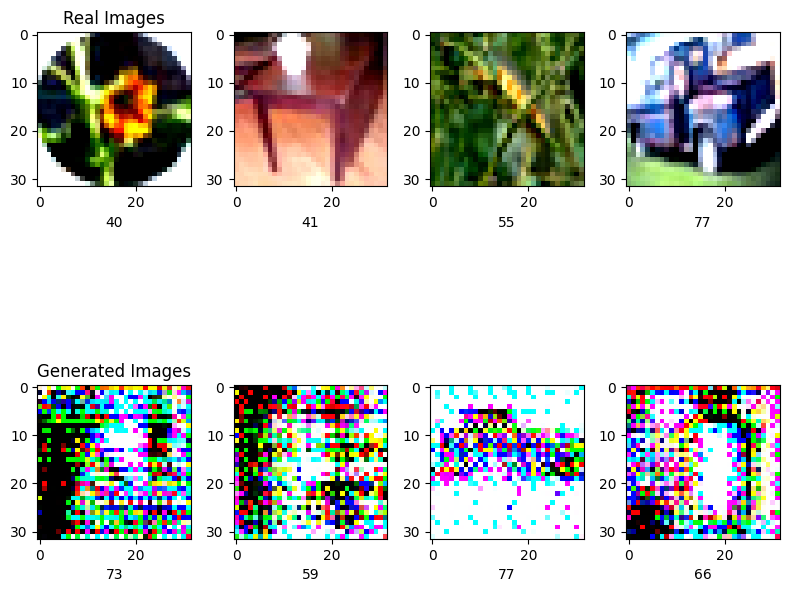

In [23]:
def denormalize(img_tensor):
    return ((img_tensor + 1) / 2).clamp(0, 1)

label_names = np.arange(100)

real_images, real_labels = next(iter(dataloader))
real_images = real_images.to(device)
real_labels = real_labels.to(device)

noise = torch.randn(real_images.size(0), latent_dim, device=device)
fake_labels = torch.randint(0, num_classes, (real_images.size(0),), device=device)
with torch.no_grad():
    fake_images = G(noise, fake_labels)

n_display = 4
real_imgs_disp = real_images[:n_display].cpu()
real_labels_disp = real_labels[:n_display].cpu().numpy()
fake_imgs_disp = fake_images[:n_display].cpu()
fake_labels_disp = fake_labels[:n_display].cpu().numpy()

fig, axes = plt.subplots(2, n_display, figsize=(n_display * 2, 8))
for i in range(n_display):
    img_real = denormalize(real_imgs_disp[i]).permute(1, 2, 0).numpy()
    axes[0, i].imshow(img_real)
    #axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title("Real Images", fontsize=12)
    axes[0, i].set_xlabel(label_names[real_labels_disp[i]])
    
    img_fake = denormalize(fake_imgs_disp[i]).permute(1, 2, 0).numpy()
    axes[1, i].imshow(img_fake)
    #axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title("Generated Images", fontsize=12)
    axes[1, i].set_xlabel(label_names[fake_labels_disp[i]])

plt.tight_layout()
plt.show()

In [24]:
dataset=My_Dataset(split=None,transform=train_transform)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

In [25]:

label_names = np.arange(100)
real_images, real_labels = next(iter(dataloader))
real_images = real_images.to(device)
real_labels = real_labels.to(device)

noise = torch.randn(real_images.size(0), latent_dim, device=device)
fake_labels = torch.randint(0, num_classes, (real_images.size(0),), device=device)
with torch.no_grad():
    fake_images = G(noise, fake_labels)

In [26]:
fake_images=denormalize(fake_images).permute(0,2, 3, 1)

In [27]:
fake_images.shape

torch.Size([9510, 32, 32, 3])

In [28]:
class generated_data(Dataset):
    def __init__(self,images=fake_images,labels=fake_labels,split='train',transform=None):
        self.images=images.cpu().numpy()
        self.labels=labels.cpu().numpy()
        self.transform=transform
        if split =='train':
             self.images, self.labels = self.images[:int(self.images.shape[0]*0.7)], self.labels[:int(self.images.shape[0]*0.7)]
        elif split =='val':
             self.images, self.labels = self.images[int(self.images.shape[0]*0.7):], self.labels[int(self.images.shape[0]*0.7):]
        else:
             self.images, self.labels = self.images, self.labels
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx): 
        image, label = self.images[idx], self.labels[idx]
  
        if self.transform: 
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image,label

In [29]:
transform = A.Compose([
    A.Resize(224,224,p=1),
    A.Normalize(),
    ToTensorV2()
])


In [30]:

train_generated=generated_data(split='train', transform=transform)
val_generated=generated_data(split='val', transform=transform)

In [31]:
train_dataset=My_Dataset(split='train', transform=transform)
val_dataset=My_Dataset(split='val',transform=transform)


In [32]:
gen_dataset_train=ConcatDataset([train_dataset,train_generated])
gen_dataset_val=ConcatDataset([val_dataset,val_generated])

gen_train_loader = DataLoader(gen_dataset_train, batch_size=32, shuffle=True)
gen_val_loader = DataLoader(gen_dataset_val, batch_size=32, shuffle=False)

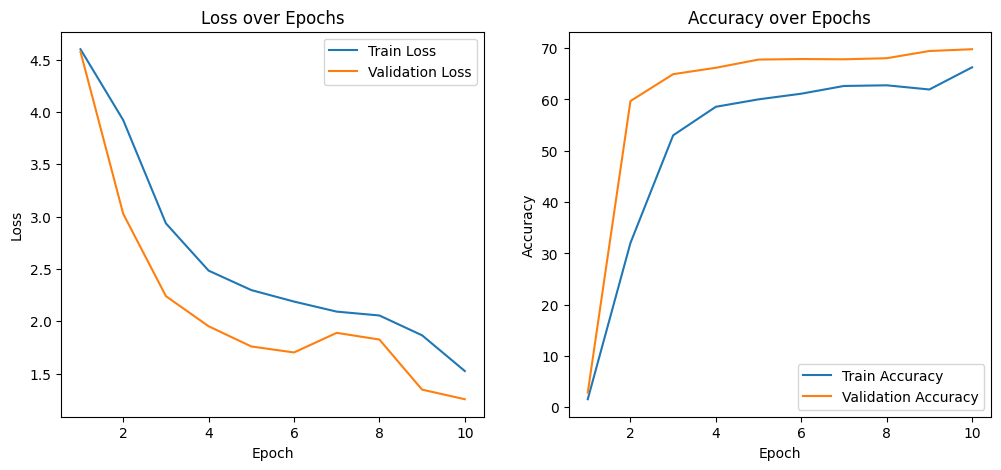

100%|██████████| 10/10 [06:31<00:00, 39.19s/it]

Epoch 10/10 | LR: 0.001000 | Train Loss: 1.5259, Train Acc: 66.27% | Val Loss: 1.2564, Val Acc: 69.80%


In [35]:
head = nn.Sequential(
    nn.Linear(num_features_efficient, num_classes)
)
class Model(nn.Module):
    def __init__(self, backbone, head):
        super(Model, self).__init__()
        self.backbone = backbone.features 
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.head = head

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1) 
        x = self.head(x) 
        return x

model = Model(backbone_efficient, head)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

learn_model(model, gen_train_loader,gen_val_loader,10)

при прогоне на кагле показал результат хуже,чем модель выбранная для выбивания скора (хотя надежды по Val Acc подавала)

# выбиваем скор 

In [4]:
#блок библиотек 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets,models
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
from tqdm import tqdm
import os

import zipfile
import seaborn as sns
import pandas as pd

import cv2
import albumentations as A
import matplotlib.pyplot as plt

from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
import os
import glob
from torch.utils.data import DataLoader

from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np


class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience #отвечает за период в течении которого не улучшается метрика 
        self.verbose = verbose
        self.counter = 0 #счетчик увеличивается каждую эпоху, если не было улучшения 
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_model_state = None

    def __call__(self, val_metric, model):
        score = -val_metric  # Assuming lower loss is better
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta: #делта чтобы не сохранялись совсем маленькие приросты 
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0
            
def warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5):
    if epoch < warmup_epochs: # пока идут эпохт вормапа lr изменяется по определенному закону 
        lr = warmup_lr_start + (base_lr - warmup_lr_start) * (epoch / warmup_epochs)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer  

In [5]:
#блок определения датасетов и скелета
class My_Dataset_upscale(Dataset):
    def __init__(self, split='train', transform=None, root_dir="content/data/",upscale=None,size=224):
        self.size=size
        self.transform = transform
        self.samples = []
        self.upscale=upscale
        
        files_train =os.path.join(root_dir,'train')
        classes = os.listdir(files_train)
        
        def split_files(files, split):
            n = len(files) 
            if split == 'train':
                return files[:int(0.7 * n)]
            elif split == 'val':
                return files[int(0.7 * n):]
            else:
                return files
                
        #train->class-> деление  на трейн и валидацию 
        for class_name in classes:
            class_dir = os.path.join(files_train,class_name) #заходим в train и затем в конкретный класс
            class_files= os.listdir(class_dir) #все файлы внутри одного класса 
            # нужно поделить все файлы внутри одного класса на trein и валидацию
            class_split=split_files(class_files,split)
            #поставили метку для каждого файла внутри класса 
            for file in class_split:
                self.samples.append((os.path.join(class_dir,file),int(class_name)))
 
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx): 
        img_path, label = self.samples[idx]  #внутри батча берем название файлика и его лейбл 
        image = cv2.imread(img_path) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.upscale=='nearest':
            image = cv2.resize(image, (self.size,self.size), interpolation=cv2.INTER_NEAREST)
        elif self.upscale=='bilinear':
            image = cv2.resize(image, (self.size,self.size), interpolation=cv2.INTER_LINEAR)
        elif self.upscale=='bicubic':
            image = cv2.resize(image, (self.size,self.size), interpolation=cv2.INTER_CUBIC)
        else:
            image=image

        
        if image is None:
          print(f"Не открывается {img_path}")
          new_idx = (idx + 1) % len(self.samples)
          return self.__getitem__(new_idx)

        if self.transform: #подаём аугументацию
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image, label
    
    
class testdata_upscale(Dataset):
    def __init__(self,transform=None, root_dir="content/data/test",upscale=None,size=224):
        self.size=size
        self.upscale=upscale
        self.transform = transform
        self.root_dir=root_dir
        self.images=sorted(os.listdir(self.root_dir)[:-1], key=lambda x: int(x.split('.')[0])) ###!!!!! сортируются файлы на тесте и почему-то там последний файл это .ipynb_checkpoints который я дропаю тк это не относиться к картинке 
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx): 
        img_path = os.path.join(self.root_dir,self.images[idx]) 
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.upscale=='nearest':
            image = cv2.resize(image, (self.size,self.size), interpolation=cv2.INTER_NEAREST)
        elif self.upscale=='bilinear':
            image = cv2.resize(image, (self.size,self.size), interpolation=cv2.INTER_LINEAR)
        elif self.upscale=='bicubic':
            image = cv2.resize(image, (self.size,self.size), interpolation=cv2.INTER_CUBIC)
            
        if self.transform: #подаём аугументацию
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

train_transform_upscale = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.PixelDropout(p=0.4),
    A.Normalize(),
    ToTensorV2()
])

val_transform_upscale = A.Compose([
    A.Normalize(),
    ToTensorV2()
])

test_transform_upscale = A.Compose([
    A.Normalize(),
    ToTensorV2()
])

train_dataset=My_Dataset_upscale(split='train',upscale='bicubic',transform=train_transform_upscale)
val_dataset=My_Dataset_upscale(split='val',upscale='bicubic',transform=val_transform_upscale)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)    

backbone_efficient=models.efficientnet_b2(weights='EfficientNet_B2_Weights.DEFAULT')
for param in backbone_efficient.parameters():
    param.requires_grad = False

num_features_efficient = backbone_efficient.classifier[-1].in_features
num_classes = 100

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 46.6MB/s]


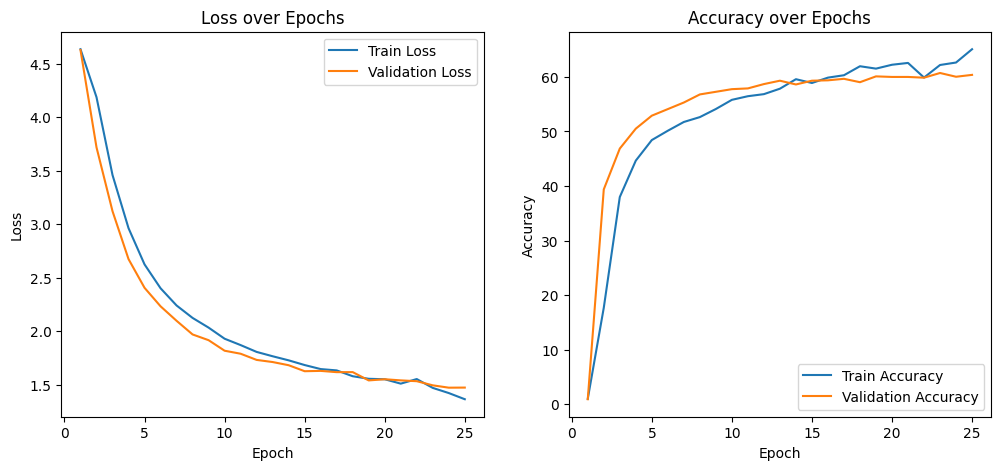

100%|██████████| 25/25 [10:53<00:00, 26.13s/it]

Epoch 25/25 | LR: 0.001000 | Train Loss: 1.3640, Train Acc: 65.07% | Val Loss: 1.4728, Val Acc: 60.37%
EarlyStopping counter: 1 out of 2


In [270]:
#блок обучения
head = nn.Sequential(
    nn.Linear(num_features_efficient, num_classes)
)
class Model(nn.Module):
    def __init__(self, backbone, head):
        super(Model, self).__init__()
        self.backbone = backbone.features 
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.head = head

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1) 
        x = self.head(x)  
        return x

model = Model(backbone_efficient, head)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
early_stopping_optimizer_switch = EarlyStopping(patience=2, verbose=True)

warmup_epochs = 2
optimizer_switched = False
base_lr = 0.01
num_epochs=25

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
#если находимся в вормапе, то меняем оптимайзер шедулера 
    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else: # вне вормапа обнавляем все по шедулеру такому 
        scheduler_step.step()

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = 100. * correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
            print("No improvement after loss switch. Switching optimizer to Adam.")
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            base_lr = 0.001
            optimizer_switched = True
            early_stopping_optimizer_switch = EarlyStopping(patience=2, verbose=True)

In [277]:
#блок предсказания
model.load_state_dict(early_stopping_optimizer_switch.best_model_state)

test_dataset=testdata_upscale(transform=test_transform_upscale,upscale='bicubic')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
test_predictions = []
for inputs in test_loader:
    inputs=inputs.to(device)
    with torch.no_grad():
        outputs=model(inputs)
        _,preds=torch.max(outputs,1)
        test_predictions.extend(preds.cpu().numpy())
print(len(test_predictions)  )      
df = pd.DataFrame(test_predictions, columns=['pred'])
tags=pd.read_csv('sample_submission.csv')
tags['target']=df.pred
tags.to_csv('end_best_guseva.csv', index=False)       